# LAB A2 - ASTR521                                                                                Matt Wilde

# 2 Saha-Boltzmann calibration of the Harvard sequence



In [77]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
#plt.rc('font', family='serif', size=15)

In [ ]:
k = 8.61734e-5 # ev/deg

### Initial estimates of the strengths of the $\alpha$ lines in the HI Lyman, Balmer, Paschen, Brackett series for the sun.

In [72]:
chiLya = 0.
#chiHa = 10.2
chiHa = 13.6*(1. - 1./(2.**2))
#chiPa = 12.09
chiPa = 13.6*(1. - 1./(3.**2))
chiBra = 13.6*(1. - 1./(4.**2))
print 'Lya / Ha = {:.2g}'.format(np.exp((chiHa - chiLya) / (k * 5600)))
print 'Lya / Pa = {:.2g}'.format(np.exp((chiPa - chiLya) / (k * 5600)))
print 'Lya / Bra = {:.2g}'.format(np.exp((chiBra - chiLya) / (k * 5600)))



12.75
Lya / Ha = 1.5e+09
Lya / Pa = 7.6e+10
Lya / Bra = 3e+11


In [42]:
# check temp scaling relations:
def boltz(T):
    return np.exp(-1./(k*T))

def saha(T):
    return boltz(T)*(k*T)**(3./2.)
    


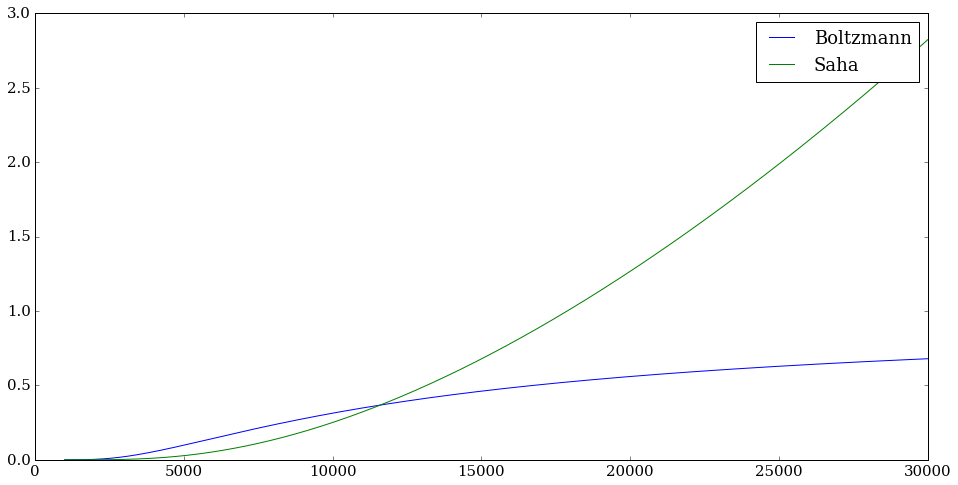

In [53]:
plt.figure(figsize=(16,8))
t = np.arange(1000,30000)
plt.plot(t,boltz(t),label='Boltzmann')
plt.plot(t,saha(t),label='Saha')
plt.legend()
plt.savefig('boltz_saha_temp.png')


In [25]:
# schadee ionization energy
chiion = np.array([7,16,31,51])
temp = 20000

In [5]:
def partfunc_E(t):
    u = np.zeros(4)
    for r in range(4):
        for s in range(chiion[r]-1):
            u[r] = u[r] + np.exp(-s/(k*t))
    #return np.sum(np.exp(-1*chiion/(k * t)))
    return u

In [6]:
print partfunc_E(5000)
print partfunc_E(10000)
print partfunc_E(20000)


[ 1.10887389  1.10887488  1.10887488  1.10887488]
[ 1.45495666  1.45633509  1.45633513  1.45633513]
[ 2.20166497  2.27117384  2.27155091  2.27155097]


In [7]:
def boltz_E(temp,r,s):
    
    """ compute Boltzmann population for level r,s of Schadee element E
     input: temp (temperature, K)
    
    r (ionization stage nr, 1 - 4 where 1 = neutral E)
    
    s (level nr, starting at s=1)
    output: relative level population n_(r,s)/N_r"""
    u=partfunc_E(temp)
    keV=8.61734e-5 # Boltzmann constant in ev/deg
    relnrs = 1./u[r-1]*np.exp(-(s-1)/(keV*temp))
    return relnrs


In [8]:
for s in range(1,11):
    print boltz_E(5000,1,s)

0.901815806468
0.0885447863016
0.00869376997493
0.00085359781794
8.3810503026e-05
8.22893436447e-06
8.07957932834e-07
7.9329350839e-08
7.78895243031e-09
7.64758305973e-10


In [9]:
def saha_E(temp,elpress,ionstage):
    """; compute Saha population fraction N_r/N for Schadee element E
    ; input: temperature, electron pressure, ion stage
    ; physics constants"""
    kerg=1.380658e-16 # Boltzmann constant (erg K; double precision)
    kev=8.61734e-5 # Boltzmann constant (eV/deg)
    h=6.62607e-27 # Planck constant (erg s)
    elmass=9.109390e-28 # electron mass (g) 
    # kT and electron density
    kevT=kev*temp
    kergT=kerg*temp
    eldens=elpress/kergT
    chiion=[7,16,31,51]
    # ionization energies for element E
    u = partfunc_E(temp) # get partition functions U[0]...u[3]
    u = np.append(u,2) # add estimated fifth value to get N_4 too
    sahaconst = (2*np.pi*elmass*kergT/(h*h))**(1.5) * 2./eldens
    nstage=np.zeros(5)
    # double-precision float array
    nstage[0]=1. # relative fractions only (no abundance)
    for r in range(0,4):
        nstage[r+1] = nstage[r]*sahaconst*u[r+1]/u[r]*np.exp(-chiion[r]/kevT)
        ntotal=np.sum(nstage) # sum all stages = element density
    nstagerel=nstage/ntotal # fractions of element density
    return nstagerel[ionstage-1] # ion stages start at 1, IDL at 0



In [10]:
for r in range(1,6):
    print saha_E(20000,1e3,r)

2.69015927103e-10
0.000180265289204
0.632005368781
0.367812645909
1.71975190167e-06


In [11]:
for r in range(1,6):
    print saha_E(20000,1e1,r)

7.18708400585e-16
4.81600398459e-08
0.0168847834643
0.982655715974
0.00045945240193


In [12]:
def sahabolt_E(temp,elpress,ion,level):
    # compute Saha-Boltzmann populaton n_(r,s)/N for level r,s of E
    # input: temperature, electron pressure, ionization stage, level nr
    return saha_E(temp,elpress,ion) * boltz_E(temp,ion,level)



In [13]:
for s in range(1,6):
    print sahabolt_E(5000,1e3,1,s)

0.817094134531
0.0802263888162
0.00787702810544
0.000773406016267
7.59368708594e-05


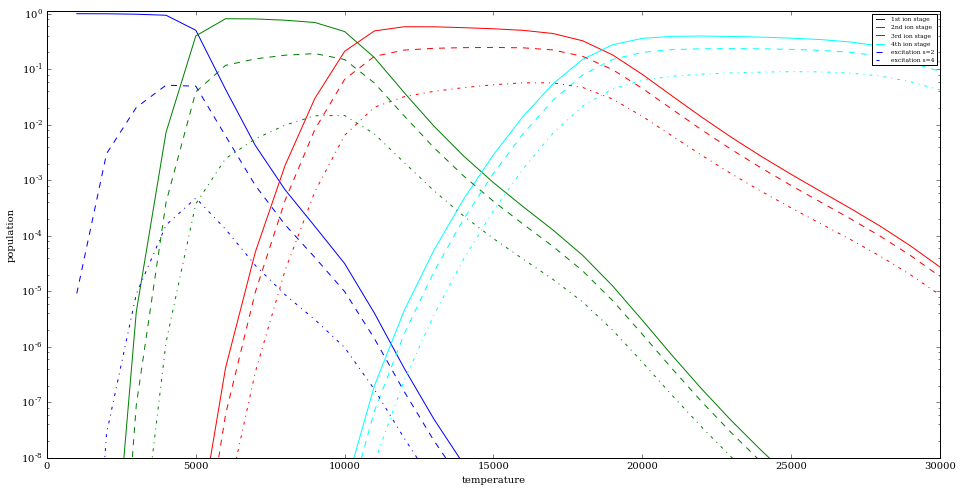

In [98]:
temp = np.arange(0,31000,1000)
# print temp # check
pop=np.zeros([5,31]) # declare float array for n(r,T)
for T in range(1,31):
    for r in range(1,5):
        pop[r,T]=sahabolt_E(temp[T],131.,r,1)

plt.figure(figsize=(16,8))

plt.ylim([1e-8,1.1])
plt.xlabel('temperature')
plt.ylabel('population')

plt.semilogy(temp,pop[1,:],'blue',label='1st ion stage')
plt.semilogy(temp,pop[2,:],'green',label='2nd ion stage')
plt.semilogy(temp,pop[3,:],'red',label='3rd ion stage')
plt.semilogy(temp,pop[4,:],'cyan',label='4th ion stage')

pop2=np.zeros([5,31]) # declare float array for n(r,T)
for T in range(1,31):
    for r in range(1,5):
        pop2[r,T]=sahabolt_E(temp[T],131.,r,2)
plt.semilogy(temp,pop2[1,:],'blue',linestyle='--',label='excitation s=2')
plt.semilogy(temp,pop2[2,:],'green',linestyle='--')
plt.semilogy(temp,pop2[3,:],'red',linestyle='--')
plt.semilogy(temp,pop2[4,:],'cyan',linestyle='--')

pop3=np.zeros([5,31]) # declare float array for n(r,T)
for T in range(1,31):
    for r in range(1,5):
        pop3[r,T]=sahabolt_E(temp[T],131.,r,4)
plt.semilogy(temp,pop3[1,:],'blue',linestyle='-.',label='excitation s=4')
plt.semilogy(temp,pop3[2,:],'green',linestyle='-.')
plt.semilogy(temp,pop3[3,:],'red',linestyle='-.')
plt.semilogy(temp,pop3[4,:],'cyan',linestyle='-.')

plt.semilogy()
plt.legend(prop={'size':6})
plt.savefig('pop_temp.png')



## 2.7 Saha-Boltzmann populations of hydrogen 

In [15]:
def sahabolt_H(temp,elpress,level):
    """ compute Saha population fraction N_r/N for H
        input: temperature, electron pressure, ion stage
        physics constants"""
    kerg=1.380658e-16 # Boltzmann constant (erg K; double precision)
    kev=8.61734e-5 # Boltzmann constant (eV/deg)
    h=6.62607e-27 # Planck constant (erg s)
    elmass=9.109390e-28 # electron mass (g) 
    # kT and electron density
    kevT=kev*temp
    kergT=kerg*temp
    eldens=elpress/kergT
    nrlevels=100
    g = np.zeros([2, nrlevels])
    chiexc = np.zeros([2, nrlevels])
    for s in range(nrlevels):
        g[0,s] = 2*(s+1)**2
        chiexc[0,s] = 13.598*(1-1./(s+1)**2)
    g[1,0]=1
    chiexc[1,0]=0. # excitation energy proton ground state
    u = np.zeros(2)
    u[0] = 0
    for s in range(nrlevels):
        u[0] = u[0] + g[0,s]*np.exp(-chiexc[0,s]/kevT)
        u[1]=g[1,0]
        
    # saha
    sahaconst = (2*np.pi*elmass*kergT/(h*h))**(1.5) * 2./eldens
    nstage=np.zeros(2)
    nstage[0]=1. # relative fractions only (no abundance)
    nstage[1] = nstage[0] * sahaconst * u[1]/u[0] * np.exp(-13.598/kevT)
    ntotal=np.sum(nstage)

    # Bolztmann
    nlevel = nstage[0]*g[0,level-1]/u[0]*np.exp(-chiexc[0,level-1]/kevT)
    nlevelrel=nlevel/ntotal # fractions of element density
    return nlevelrel

# 2.8 Solar Ca+ K versus Hα: line strength


In [16]:
chiion = np.array([6,12,52,67])
def partfunc_Ca(t):
    u = np.zeros(4)
    for r in range(4):
        for s in range(chiion[r]-1):
            u[r] = u[r] + np.exp(-s/(k*t))
    return u

def boltz_Ca(temp,r,s):
    
    """ compute Boltzmann population for level r,s of Schadee element E
     input: temp (temperature, K)
    
    r (ionization stage nr, 1 - 4 where 1 = neutral E)
    
    s (level nr, starting at s=1)
    output: relative level population n_(r,s)/N_r"""
    u=partfunc_Ca(temp)
    keV=8.61734e-5 # Boltzmann constant in ev/deg
    relnrs = 1./u[r-1]*np.exp(-(s-1)/(keV*temp))
    return relnrs

def saha_Ca(temp,elpress,ionstage):
    """; compute Saha population fraction N_r/N for Schadee element E
    ; input: temperature, electron pressure, ion stage
    ; physics constants"""
    kerg=1.380658e-16 # Boltzmann constant (erg K; double precision)
    kev=8.61734e-5 # Boltzmann constant (eV/deg)
    h=6.62607e-27 # Planck constant (erg s)
    elmass=9.109390e-28 # electron mass (g) 
    # kT and electron density
    kevT=kev*temp
    kergT=kerg*temp
    eldens=elpress/kergT
    chiion = np.array([6,12,52,67], dtype=int)
    # ionization energies for element E
    u = partfunc_Ca(temp) # get partition functions U[0]...u[3]
    u = np.append(u,2) # add estimated fifth value to get N_4 too
    sahaconst = (2*np.pi*elmass*kergT/(h*h))**(1.5) * 2./eldens
    nstage=np.zeros(5)
    # double-precision float array
    nstage[0]=1. # relative fractions only (no abundance)
    for r in range(0,4):
        nstage[r+1] = nstage[r]*sahaconst*u[r+1]/u[r]*np.exp(-chiion[r]/kevT)
        ntotal=np.sum(nstage) # sum all stages = element density
    nstagerel=nstage/ntotal # fractions of element density
    return nstagerel[ionstage-1] # ion stages start at 1, IDL at 0

def sahabolt_Ca(temp,elpress,ion,level):
    # compute Saha-Boltzmann populaton n_(r,s)/N for level r,s of E
    # input: temperature, electron pressure, ionization stage, level nr
    return saha_Ca(temp,elpress,ion) * boltz_Ca(temp,ion,level)



Plot

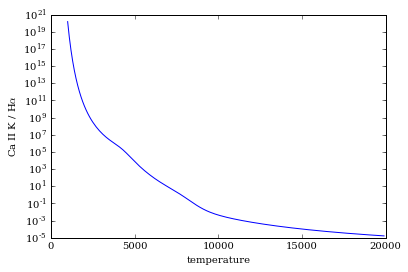

In [82]:
temp = np.arange(1000,20000,100, dtype=float)
CaH = np.zeros_like(temp)
Caabund=2e-6
for i in range(190):
    NCa = sahabolt_Ca(temp[i],1e2,2,1)
    NH = sahabolt_H(temp[i],1e2,2)
    CaH[i]=NCa*Caabund/NH

# plt.figure(figsize=(16,8))
plt.semilogy(temp, CaH)
plt.xlabel('temperature')
plt.ylabel(r'Ca II K / H$\alpha$')
plt.savefig('CaH_ratio.png')

In [91]:
print 'Ca/H ratio at 5000K = {:.7}'.format(CaH[(temp > 4900) & (temp < 5100)][0])


Ca/H ratio at 5000K = 7841.85


# 2.9 Solar Ca+ K versus Hα: temperature sensitivity


In [93]:
# temperature sensitivity CaIIK and Halpha
temp=np.arange(200,12000, 100, dtype=float) # T = 2000-12000, delta T = 100
dNCadT =  np.zeros_like(temp) # declare array
dNHdT = np.zeros_like(temp) # declare array
dT=1.

for i in range(0,101):
    NCa = sahabolt_Ca(temp[i],1e2,2,1) # Ca ion ground state
    NCa2 = sahabolt_Ca(temp[i]-dT,1e2,2,1) # idem dT cooler
    dNCadT[i]= (NCa - NCa2)/dT/NCa # fractional diff quotient
    NH = sahabolt_H(temp[i],1e2,2) # H atom 2nd level
    NH2 = sahabolt_H(temp[i]-dT,1e2,2) # idem dT cooler
    dNHdT[i] = (NH-NH2)/dT/NH # fractional diff quotient

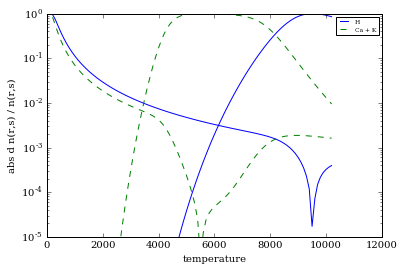

In [96]:
# Plot
#plt.figure(figsize=(16,8))
plt.semilogy(temp,abs(dNHdT),label='H'),
plt.ylim([1e-5,1])
plt.xlabel('temperature')
plt.ylabel('abs d n(r,s) / n(r,s)')

plt.semilogy(temp,abs(dNCadT),linestyle='--',label='Ca + K') # Ca curve dashed
plt.legend(prop={'size':6})


# recompute as arrays and overplot relative populations
NCa = np.zeros_like(temp)
NH = np.zeros_like(temp)

for i in range(0,101):
    NCa[i] = sahabolt_Ca(temp[i],1e2,2,1)
    NH[i] = sahabolt_H(temp[i],1e2,2)

plt.semilogy(temp,NH/max(NH), color='blue')
plt.semilogy(temp,NCa/max(NCa),linestyle='--', color='green')

plt.savefig('temp_sensitivity.png')



**Each dip has a $\Delta$n > 0 and a $\Delta$n < 0 flank. Which is which?**

The $\Delta$n > 0 is the left flank while the right side is the $\Delta$n < 0 since the right flank for Hydrogen is being ionized taking it out of the n=2 state.

For Ca+ K the there is the same derivative behaivior but for different reasons. The ionization is taking place to put more and more ions in the system unitl the population is completely ionized and in the n=1 level. The right flank Bolztmann excitation is taking the ions out of their ground state. 




**Explain each flank of the two population curves and the dips in the two temperature sensitivity curves.**

The left flank of the population curves are increasing for two different reasons. For Ca+ K, the left flank ionization of the Ca to Ca+ while the right flank the population is decreasing due to Boltzmann excitation out of the ground state. For H, the left flank is exitation to the n=2 level while the right flank, the population is decreasing due to  ionization of H. The dips occur when the population is entirely in the ground state of the transition. 

# 2.10 Hot stars versus cool stars

In [21]:
for T in range(2000,22000,2000):
    print T,sahabolt_H(T,1e2,1)

2000 1.0
4000 0.999999999972
6000 0.999963500508
8000 0.949916411741
10000 0.174714680568
12000 0.00961626988066
14000 0.0010102935488
16000 0.000177209541791
18000 4.41674730262e-05
20000 1.41328610151e-05


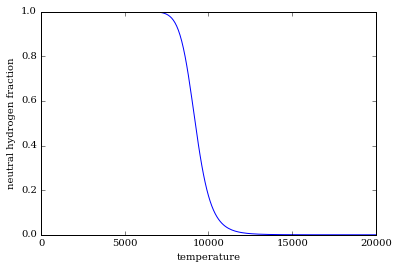

In [100]:
temp = np.arange(191)*100 + 1000.
nH = np.zeros_like(temp)
#for i in range(190):
for i,t in enumerate(temp):
    nH[i] = sahabolt_H(t, 1e2,1)

    
#plt.figure(figsize=(16,8))
plt.plot(temp, nH)
plt.xlabel('temperature')
plt.ylabel('neutral hydrogen fraction')
plt.savefig('hot_cool.png')

**At which temperature is the hydrogen in stellar photospheres with Pe = 102 is about
50% ionized?**

H is 50% ionized at 10000K